In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def simulate_fixed_threshold(N, p_stop, tau, num_trials=10000):
    scores = []
    for _ in range(num_trials):
        house_values = np.random.uniform(0, 1, N)
        for i, x in enumerate(house_values):
            if x >= tau or np.random.rand() < p_stop:
                scores.append(x)
                break
    return np.mean(scores)

In [4]:
def simulate_exploration(N, p_stop, exploration_fraction=0.37, num_trials=10000):
    scores = []
    for _ in range(num_trials):
        house_values = np.random.uniform(0, 1, N)
        k = int(exploration_fraction * N)  # Number of houses to explore
        best_seen = max(house_values[:k])
        for i in range(k, N):
            if house_values[i] > best_seen or np.random.rand() < p_stop:
                scores.append(house_values[i])
                break
    return np.mean(scores)

In [5]:
# Parameters
N = 1000  # Expected number of visits (1/p_stop)
p_stop = 1/N  # Setting stopping probability accordingly
tau_values = np.linspace(0.5, 0.9, 10)

In [6]:
# Run simulations for different tau values
fixed_threshold_results = [simulate_fixed_threshold(N, p_stop, tau) for tau in tau_values]
exploration_result = simulate_exploration(N, p_stop)

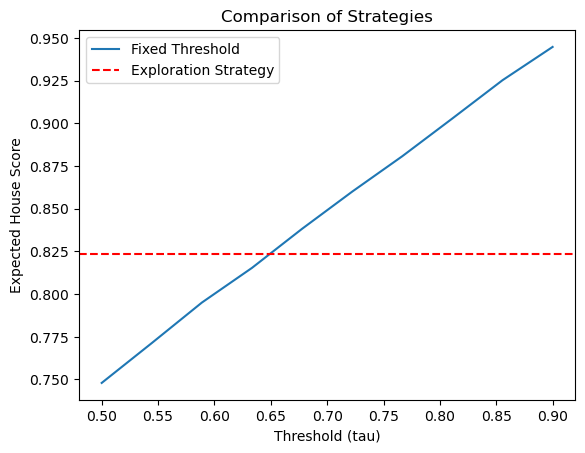

In [7]:
# Plot results
plt.plot(tau_values, fixed_threshold_results, label="Fixed Threshold")
plt.axhline(exploration_result, color='r', linestyle='--', label="Exploration Strategy")
plt.xlabel("Threshold (tau)")
plt.ylabel("Expected House Score")
plt.title("Comparison of Strategies")
plt.legend()
plt.show()

In [8]:
# Given context variables
mu_D = 100  # Mean demand (unknown to vendor)
tau_D = 10   # Std dev of demand

m = 1   # Stockout penalty per item
s = 3   # Cleanup cost per excess item
c = 5   # Purchase cost per item
p = 10  # Selling price per item

sigma_N = 5  # Given variance for order policy

num_simulations = 1000  # Number of rollouts per theta
theta_values = np.linspace(80, 120, 20)  # Range of theta values to test


In [9]:
# Function to compute the reward for a given theta
def simulate_inventory(theta):
    total_reward = 0
    for _ in range(num_simulations):
        # Sample demand and order quantity
        D = np.random.normal(mu_D, tau_D)  # True demand (unknown to vendor)
        N = np.random.normal(theta, sigma_N)  # Ordered quantity

        # Compute revenue, costs, cleanup, and stockout penalties
        revenue = p * min(N, D)
        cost = c * N
        cleanup_cost = s * max(0, N - D)
        stockout_penalty = m * max(0, D - N)

        # Compute reward
        reward = revenue - cost - cleanup_cost - stockout_penalty
        total_reward += reward

    return total_reward / num_simulations  # Average reward

In [10]:
# Evaluate different values of theta
theta_rewards = {theta: simulate_inventory(theta) for theta in theta_values}

# Find the best theta
optimal_theta = max(theta_rewards, key=theta_rewards.get)
optimal_theta, theta_rewards[optimal_theta]

(96.84210526315789, 439.11683906821827)

In [11]:
# Policy Gradient Reinforcement Learning Implementation

# Hyperparameters
alpha = 0.1  # Learning rate
num_iterations = 500  # Number of policy updates
theta = 90  # Initial guess for theta
baseline = theta_rewards[optimal_theta]  # Use the benchmarked optimal reward as baseline

# Track theta updates
theta_history = []

# Policy Gradient Algorithm
for _ in range(num_iterations):
    # Sample N from the current policy
    N = np.random.normal(theta, sigma_N)

    # Sample demand D
    D = np.random.normal(mu_D, tau_D)

    # Compute reward components
    revenue = p * min(N, D)
    cost = c * N
    cleanup_cost = s * max(0, N - D)
    stockout_penalty = m * max(0, D - N)
    reward = revenue - cost - cleanup_cost - stockout_penalty

    # Compute policy gradient update
    gradient = (reward - baseline) * (N - theta) / (sigma_N ** 2)
    theta += alpha * gradient

    # Store the theta value
    theta_history.append(theta)

theta, theta_history[-10:]  # Final theta and last 10 updates to see convergence


(110.14657451890653,
 [124.96272638902106,
  125.74466054704888,
  126.6123230828852,
  112.9526497841008,
  107.74691687116236,
  107.4457175164955,
  110.62010743474325,
  110.60258363628279,
  110.57913895186854,
  110.14657451890653])

In [12]:
# Test different values of sigma to analyze its effect on results
sigma_values = [1, 3, 5, 10, 15]  # Different levels of variability in order quantity
sigma_results = {}

for sigma_test in sigma_values:
    theta_test = 90  # Reset initial theta
    for _ in range(num_iterations):
        N = np.random.normal(theta_test, sigma_test)
        D = np.random.normal(mu_D, tau_D)

        # Compute reward components
        revenue = p * min(N, D)
        cost = c * N
        cleanup_cost = s * max(0, N - D)
        stockout_penalty = m * max(0, D - N)
        reward = revenue - cost - cleanup_cost - stockout_penalty

        # Compute policy gradient update
        gradient = (reward - baseline) * (N - theta_test) / (sigma_test ** 2)
        theta_test += alpha * gradient

    # Store final theta
    sigma_results[sigma_test] = theta_test

sigma_results


{1: 109.44472843728373,
 3: 93.01841240871497,
 5: 110.00359603413678,
 10: 96.70757451419426,
 15: 95.61182570506536}